# Classifying the Pandora Dataset

In [1]:
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from skimage import feature
import glob
import os
import cv2
import seaborn as sns

## Importing Data

 - Import Images
 - Get Class Labels
 - Get Categories


In [2]:
#print(next(os.walk('F:\\datamining\\rawdata'))[1])
class_labels = []
categories = []
category_count = 0
images_total = []
raw_data = "F:\\datamining\\rawdata"

for item in os.listdir(raw_data):
    img_dir = os.path.join(raw_data, item)
    categories.append(item)
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    
    for f1 in files:
        img = cv2.imread(f1)
        images_total.append(img)
        class_labels.append(category_count)
    category_count+=1

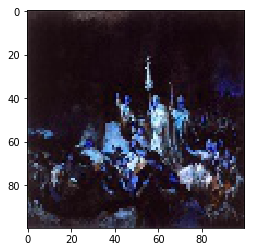

In [3]:
plt.imshow(images_total[1056])

## Processing the Data

### Feature Extraction
Convert images to grayscale

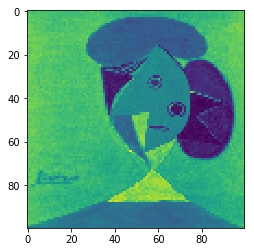

In [4]:
images_gray = [ color.rgb2gray(i) for i in images_total]
plt.imshow(images_gray[100])

Extract HOG Features

In [5]:
ppc = 16
hog_images = []
hog_features = []
for image in images_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualise=True)
    hog_images.append(hog_image)
    hog_features.append(fd)


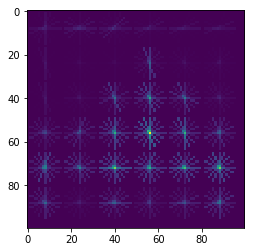

In [6]:
plt.imshow(hog_images[1056])

 ### Creating the Test and Training Datasets
 Combining Extracted Features and Class Labels <br> Shuffling the data

In [7]:
class_labels=np.array(class_labels).reshape(len(class_labels),1)
data_total = np.array(hog_features)
data_frame = np.hstack((data_total,class_labels))
np.random.shuffle(data_frame)

Partitioning the Data into Test and Training sets

In [8]:
percentage = 80
partition = int(len(data_total)*percentage/100)
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

## Classifying the Data
### Random Forest Classifier
Create and train the classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)

Accuracy of the Random Forest Classifier

In [10]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred,target_names=categories))


Accuracy: 0.7103064066852368


             precision    recall  f1-score   support

     Cubism       0.71      0.74      0.72       185
Romanticism       0.71      0.68      0.70       174

avg / total       0.71      0.71      0.71       359



In [11]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [
    KNeighborsClassifier(3),
    NuSVC(probability=True),
    LinearSVC(C=100.0, random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

In [12]:
for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('Results')
    print('\n')
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, y_pred,target_names=categories))
    
    

KNeighborsClassifier
Results


Accuracy: 66.8524%
             precision    recall  f1-score   support

     Cubism       0.64      0.81      0.72       185
Romanticism       0.72      0.52      0.60       174

avg / total       0.68      0.67      0.66       359

NuSVC
Results


Accuracy: 66.8524%
             precision    recall  f1-score   support

     Cubism       0.69      0.65      0.67       185
Romanticism       0.65      0.69      0.67       174

avg / total       0.67      0.67      0.67       359

LinearSVC
Results


Accuracy: 65.7382%
             precision    recall  f1-score   support

     Cubism       0.66      0.69      0.67       185
Romanticism       0.65      0.63      0.64       174

avg / total       0.66      0.66      0.66       359

DecisionTreeClassifier
Results


Accuracy: 65.1811%
             precision    recall  f1-score   support

     Cubism       0.66      0.65      0.66       185
Romanticism       0.64      0.65      0.64       174

avg / total       

## Feature Extraction - Local Binary Patterns

In [13]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
 
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
 
        # return the histogram of Local Binary Patterns
        return hist

Finding local binary patterns of numPoints 24 and radius 8 pixels

In [14]:
desc = LocalBinaryPatterns(24, 8)

In [15]:
lbp_features = []
for image in images_gray:
    hist = desc.describe(image)
    lbp_features.append(hist)

C:\Users\Shruti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


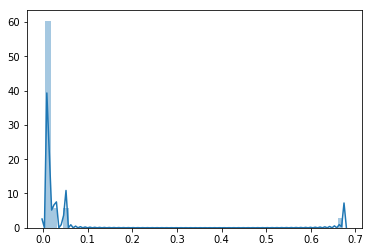

In [16]:
sns.distplot(lbp_features[100])

## Partitioning and Classifiying Data - LBP 

In [17]:
data_frame = np.hstack((lbp_features,class_labels))
np.random.shuffle(data_frame)

In [18]:
percentage = 80
partition = int(len(data_total)*percentage/100)
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

In [19]:
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred,target_names=categories))

Accuracy: 0.7298050139275766


             precision    recall  f1-score   support

     Cubism       0.77      0.71      0.73       190
Romanticism       0.70      0.76      0.73       169

avg / total       0.73      0.73      0.73       359



In [20]:
classifiers = [
    KNeighborsClassifier(3),
    NuSVC(probability=True),
    LinearSVC(C=100.0, random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('Results')
    print('\n')
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, y_pred,target_names=categories))

KNeighborsClassifier
Results


Accuracy: 70.4735%
             precision    recall  f1-score   support

     Cubism       0.76      0.65      0.70       190
Romanticism       0.66      0.77      0.71       169

avg / total       0.71      0.70      0.70       359

NuSVC
Results


Accuracy: 67.9666%
             precision    recall  f1-score   support

     Cubism       0.87      0.46      0.60       190
Romanticism       0.60      0.92      0.73       169

avg / total       0.75      0.68      0.66       359

LinearSVC
Results


Accuracy: 73.5376%
             precision    recall  f1-score   support

     Cubism       0.78      0.69      0.74       190
Romanticism       0.69      0.78      0.74       169

avg / total       0.74      0.74      0.74       359

DecisionTreeClassifier
Results


Accuracy: 67.6880%
             precision    recall  f1-score   support

     Cubism       0.69      0.70      0.70       190
Romanticism       0.66      0.65      0.65       169

avg / total       